In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt

import SearchingOptimalEnsembles.metadatasets.quicktune.metadataset as qmd
import SearchingOptimalEnsembles.metadatasets.scikit_learn.metadataset as slmd
try: 
    import SearchingOptimalEnsembles.metadatasets.tabrepo.metadataset as trmd
except ImportError:
    trmd = None
import SearchingOptimalEnsembles.metadatasets.nasbench201.metadataset as nbmd

from SearchingOptimalEnsembles.posthoc.neural_ensembler import NeuralEnsembler
from sklearn.metrics import f1_score

/home/pineda/anaconda3/envs/searching_optimal_ensembles/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 13.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(
/home/pineda/anaconda3/envs/searching_optimal_ensembles/lib/python3.10/site-packages/dask/dataframe/__init__.py:31: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [2]:
DATA_DIR = "/work/dlclarge2/janowski-quicktune/predictions"
md_class = qmd.QuicktuneMetaDataset
metric_name = "error"
data_version = "micro"
task_id = 0

metadataset = md_class(
    data_dir=DATA_DIR, metric_name=metric_name, data_version=data_version
)



In [31]:

def get_weights_and_scores(dataset_name, dropout_rate):
    metadataset.set_state(dataset_name)
    ne = NeuralEnsembler(metadataset=metadataset,
                            ne_add_y=True,
                            ne_use_context=True,
                            learning_rate=0.0001,
                            epochs=1000,
                            ne_reg_term_div=0.0,
                            ne_reg_term_norm=0.,
                            ne_num_layers=3,
                            ne_num_heads=1,
                            ne_context_size=256,
                            ne_hidden_dim=32,
                            ne_use_mask=True,
                            ne_eval_context_size=128,
                            ne_resume_from_checkpoint=False,
                            ne_unique_weights_per_function=False,
                            ne_dropout_rate=dropout_rate,
                            use_wandb=False,
                            ne_net_mode="model_averaging",
                            ne_net_type="ffn")

    X_obs = [i.item() for i in metadataset.hp_candidates_ids]

    best_ensemble, best_metric = ne.sample(X_obs)
    weights = ne.get_weights(X_obs)
    predictions = metadataset.get_predictions([X_obs])
    y_true = metadataset.get_targets().numpy()

    f1_scores = []
    for i in range(predictions.shape[1]):
        y_pred = predictions[0][i].argmax(-1).numpy()
        f1_scores.append(f1_score(y_true, y_pred, average="weighted"))
    f1_scores = np.array(f1_scores)
    weights = weights[0].mean(axis=(-1,-2))
    return weights,f1_scores



/home/pineda/SearchingOptimalEnsembles/SearchingOptimalEnsembles/posthoc/neural_ensembler.py:423: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.long)


Epoch 0 Loss 1.4070782661437988
Epoch 1 Loss 1.40923273563385
Epoch 2 Loss 1.4088975191116333
Epoch 3 Loss 1.4136676788330078
Epoch 4 Loss 1.406791090965271
Epoch 5 Loss 1.4119102954864502
Epoch 6 Loss 1.410442590713501
Epoch 7 Loss 1.403874397277832
Epoch 8 Loss 1.4109421968460083
Epoch 9 Loss 1.4079508781433105
Epoch 10 Loss 1.4101139307022095
Epoch 11 Loss 1.413949966430664
Epoch 12 Loss 1.408013939857483
Epoch 13 Loss 1.413591742515564
Epoch 14 Loss 1.4136590957641602
Epoch 15 Loss 1.4085168838500977
Epoch 16 Loss 1.4088383913040161
Epoch 17 Loss 1.3984415531158447
Epoch 18 Loss 1.4177616834640503
Epoch 19 Loss 1.4008430242538452
Epoch 20 Loss 1.3988661766052246
Epoch 21 Loss 1.4065828323364258
Epoch 22 Loss 1.4027131795883179
Epoch 23 Loss 1.4049512147903442
Epoch 24 Loss 1.4073258638381958
Epoch 25 Loss 1.3990682363510132
Epoch 26 Loss 1.4044629335403442
Epoch 27 Loss 1.4002758264541626
Epoch 28 Loss 1.4020766019821167
Epoch 29 Loss 1.4075926542282104
Epoch 30 Loss 1.406718373298

/home/pineda/SearchingOptimalEnsembles/SearchingOptimalEnsembles/posthoc/neural_ensembler.py:423: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.long)


Epoch 0 Loss 1.4020979404449463
Epoch 1 Loss 1.4049794673919678
Epoch 2 Loss 1.3986127376556396
Epoch 3 Loss 1.391935110092163
Epoch 4 Loss 1.3942697048187256
Epoch 5 Loss 1.3924460411071777
Epoch 6 Loss 1.3882725238800049
Epoch 7 Loss 1.4020851850509644
Epoch 8 Loss 1.390707015991211
Epoch 9 Loss 1.382636308670044
Epoch 10 Loss 1.3890262842178345
Epoch 11 Loss 1.401358962059021
Epoch 12 Loss 1.3929344415664673
Epoch 13 Loss 1.398948073387146
Epoch 14 Loss 1.4072163105010986
Epoch 15 Loss 1.3919888734817505
Epoch 16 Loss 1.4023094177246094
Epoch 17 Loss 1.3799561262130737
Epoch 18 Loss 1.4015268087387085
Epoch 19 Loss 1.3947930335998535
Epoch 20 Loss 1.3924118280410767
Epoch 21 Loss 1.3949285745620728
Epoch 22 Loss 1.3998922109603882
Epoch 23 Loss 1.3873789310455322
Epoch 24 Loss 1.4046680927276611
Epoch 25 Loss 1.3969415426254272
Epoch 26 Loss 1.3936028480529785
Epoch 27 Loss 1.387493371963501
Epoch 28 Loss 1.4028362035751343
Epoch 29 Loss 1.3867480754852295
Epoch 30 Loss 1.3949048519

/home/pineda/SearchingOptimalEnsembles/SearchingOptimalEnsembles/posthoc/neural_ensembler.py:423: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.long)


Epoch 0 Loss 1.4081281423568726
Epoch 1 Loss 1.3951411247253418
Epoch 2 Loss 1.395491361618042
Epoch 3 Loss 1.401261329650879
Epoch 4 Loss 1.4038183689117432
Epoch 5 Loss 1.3958632946014404
Epoch 6 Loss 1.390192985534668
Epoch 7 Loss 1.4104607105255127
Epoch 8 Loss 1.3936702013015747
Epoch 9 Loss 1.3978239297866821
Epoch 10 Loss 1.404129981994629
Epoch 11 Loss 1.4061225652694702
Epoch 12 Loss 1.391660451889038
Epoch 13 Loss 1.3843666315078735
Epoch 14 Loss 1.400251865386963
Epoch 15 Loss 1.3881758451461792
Epoch 16 Loss 1.3963414430618286
Epoch 17 Loss 1.3906376361846924
Epoch 18 Loss 1.3972020149230957
Epoch 19 Loss 1.3938841819763184
Epoch 20 Loss 1.4066072702407837
Epoch 21 Loss 1.4033339023590088
Epoch 22 Loss 1.3989604711532593
Epoch 23 Loss 1.3848400115966797
Epoch 24 Loss 1.3995057344436646
Epoch 25 Loss 1.4128667116165161
Epoch 26 Loss 1.3993622064590454
Epoch 27 Loss 1.3864126205444336
Epoch 28 Loss 1.3889851570129395
Epoch 29 Loss 1.393650770187378
Epoch 30 Loss 1.38522040843

/home/pineda/SearchingOptimalEnsembles/SearchingOptimalEnsembles/posthoc/neural_ensembler.py:423: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.long)


Epoch 0 Loss 1.400031566619873
Epoch 1 Loss 1.4103620052337646
Epoch 2 Loss 1.4047596454620361
Epoch 3 Loss 1.3988760709762573
Epoch 4 Loss 1.4032317399978638
Epoch 5 Loss 1.4067314863204956
Epoch 6 Loss 1.4091556072235107
Epoch 7 Loss 1.4099090099334717
Epoch 8 Loss 1.4220991134643555
Epoch 9 Loss 1.4153404235839844
Epoch 10 Loss 1.4015473127365112
Epoch 11 Loss 1.4041677713394165
Epoch 12 Loss 1.4084264039993286
Epoch 13 Loss 1.4076648950576782
Epoch 14 Loss 1.4070628881454468
Epoch 15 Loss 1.4078458547592163
Epoch 16 Loss 1.4056137800216675
Epoch 17 Loss 1.4025757312774658
Epoch 18 Loss 1.401815414428711
Epoch 19 Loss 1.4123198986053467
Epoch 20 Loss 1.4075498580932617
Epoch 21 Loss 1.3993046283721924
Epoch 22 Loss 1.405185580253601
Epoch 23 Loss 1.4112532138824463
Epoch 24 Loss 1.3984110355377197
Epoch 25 Loss 1.398741364479065
Epoch 26 Loss 1.408711552619934
Epoch 27 Loss 1.3995566368103027
Epoch 28 Loss 1.3918230533599854
Epoch 29 Loss 1.4042452573776245
Epoch 30 Loss 1.398612380

/home/pineda/SearchingOptimalEnsembles/SearchingOptimalEnsembles/posthoc/neural_ensembler.py:423: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.long)


Epoch 0 Loss 1.417283058166504
Epoch 1 Loss 1.4165236949920654
Epoch 2 Loss 1.408726453781128
Epoch 3 Loss 1.409091591835022
Epoch 4 Loss 1.403851866722107
Epoch 5 Loss 1.40909743309021
Epoch 6 Loss 1.3979874849319458
Epoch 7 Loss 1.4128376245498657
Epoch 8 Loss 1.3967493772506714
Epoch 9 Loss 1.4109638929367065
Epoch 10 Loss 1.4062870740890503
Epoch 11 Loss 1.4051378965377808
Epoch 12 Loss 1.3984004259109497
Epoch 13 Loss 1.4008158445358276
Epoch 14 Loss 1.4098470211029053
Epoch 15 Loss 1.4184473752975464
Epoch 16 Loss 1.3978166580200195
Epoch 17 Loss 1.396679401397705
Epoch 18 Loss 1.4008108377456665
Epoch 19 Loss 1.4052035808563232
Epoch 20 Loss 1.4170417785644531
Epoch 21 Loss 1.4058407545089722
Epoch 22 Loss 1.4030004739761353
Epoch 23 Loss 1.3970118761062622
Epoch 24 Loss 1.3998123407363892
Epoch 25 Loss 1.4066522121429443
Epoch 26 Loss 1.4026870727539062
Epoch 27 Loss 1.3946239948272705
Epoch 28 Loss 1.4051307439804077
Epoch 29 Loss 1.399622917175293
Epoch 30 Loss 1.395659208297

/home/pineda/SearchingOptimalEnsembles/SearchingOptimalEnsembles/posthoc/neural_ensembler.py:423: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.long)


Epoch 0 Loss 1.410241723060608
Epoch 1 Loss 1.4093897342681885
Epoch 2 Loss 1.404587745666504
Epoch 3 Loss 1.4098541736602783
Epoch 4 Loss 1.3981964588165283
Epoch 5 Loss 1.4134045839309692
Epoch 6 Loss 1.411077618598938
Epoch 7 Loss 1.405256748199463
Epoch 8 Loss 1.401529312133789
Epoch 9 Loss 1.4065989255905151
Epoch 10 Loss 1.397695541381836
Epoch 11 Loss 1.4033323526382446
Epoch 12 Loss 1.4063678979873657
Epoch 13 Loss 1.3964017629623413
Epoch 14 Loss 1.4189895391464233
Epoch 15 Loss 1.4049582481384277
Epoch 16 Loss 1.3995683193206787
Epoch 17 Loss 1.4027700424194336
Epoch 18 Loss 1.409489631652832
Epoch 19 Loss 1.4021642208099365
Epoch 20 Loss 1.4017754793167114
Epoch 21 Loss 1.398569107055664
Epoch 22 Loss 1.4059809446334839
Epoch 23 Loss 1.400867223739624
Epoch 24 Loss 1.3916115760803223
Epoch 25 Loss 1.3982809782028198
Epoch 26 Loss 1.3926265239715576
Epoch 27 Loss 1.4050467014312744
Epoch 28 Loss 1.3975179195404053
Epoch 29 Loss 1.3853929042816162
Epoch 30 Loss 1.3985887765884

/home/pineda/SearchingOptimalEnsembles/SearchingOptimalEnsembles/posthoc/neural_ensembler.py:423: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.long)


Epoch 0 Loss 1.4015799760818481
Epoch 1 Loss 1.407918930053711
Epoch 2 Loss 1.3904263973236084
Epoch 3 Loss 1.406761646270752
Epoch 4 Loss 1.397122859954834
Epoch 5 Loss 1.3987631797790527
Epoch 6 Loss 1.3882062435150146
Epoch 7 Loss 1.394608974456787
Epoch 8 Loss 1.4013340473175049
Epoch 9 Loss 1.405523419380188
Epoch 10 Loss 1.3994568586349487
Epoch 11 Loss 1.396445870399475
Epoch 12 Loss 1.3997206687927246
Epoch 13 Loss 1.3999007940292358
Epoch 14 Loss 1.3959499597549438
Epoch 15 Loss 1.39986252784729
Epoch 16 Loss 1.4007693529129028
Epoch 17 Loss 1.3974709510803223
Epoch 18 Loss 1.4001193046569824
Epoch 19 Loss 1.4007785320281982
Epoch 20 Loss 1.399308681488037
Epoch 21 Loss 1.407145619392395
Epoch 22 Loss 1.3915120363235474
Epoch 23 Loss 1.4028711318969727
Epoch 24 Loss 1.4049484729766846
Epoch 25 Loss 1.3908207416534424
Epoch 26 Loss 1.412641167640686
Epoch 27 Loss 1.4015250205993652
Epoch 28 Loss 1.3946571350097656
Epoch 29 Loss 1.4088839292526245
Epoch 30 Loss 1.400349736213684

/home/pineda/SearchingOptimalEnsembles/SearchingOptimalEnsembles/posthoc/neural_ensembler.py:423: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.long)


Epoch 0 Loss 1.3988686800003052
Epoch 1 Loss 1.4078905582427979
Epoch 2 Loss 1.3966999053955078
Epoch 3 Loss 1.3939849138259888
Epoch 4 Loss 1.4009015560150146
Epoch 5 Loss 1.3964051008224487
Epoch 6 Loss 1.4014424085617065
Epoch 7 Loss 1.4038584232330322
Epoch 8 Loss 1.401898980140686
Epoch 9 Loss 1.4112199544906616
Epoch 10 Loss 1.399043321609497
Epoch 11 Loss 1.404750943183899
Epoch 12 Loss 1.406158447265625
Epoch 13 Loss 1.3979960680007935
Epoch 14 Loss 1.4045135974884033
Epoch 15 Loss 1.3875749111175537
Epoch 16 Loss 1.4070707559585571
Epoch 17 Loss 1.3925731182098389
Epoch 18 Loss 1.3951640129089355
Epoch 19 Loss 1.3970415592193604
Epoch 20 Loss 1.4015127420425415
Epoch 21 Loss 1.398222804069519
Epoch 22 Loss 1.4009546041488647
Epoch 23 Loss 1.3961431980133057
Epoch 24 Loss 1.3949452638626099
Epoch 25 Loss 1.4004977941513062
Epoch 26 Loss 1.4058022499084473
Epoch 27 Loss 1.404439926147461
Epoch 28 Loss 1.3961460590362549
Epoch 29 Loss 1.400156855583191
Epoch 30 Loss 1.40745353698

/home/pineda/SearchingOptimalEnsembles/SearchingOptimalEnsembles/posthoc/neural_ensembler.py:423: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.long)


Epoch 0 Loss 1.4127439260482788
Epoch 1 Loss 1.4095286130905151
Epoch 2 Loss 1.4087940454483032
Epoch 3 Loss 1.3976502418518066
Epoch 4 Loss 1.4021116495132446
Epoch 5 Loss 1.4054758548736572
Epoch 6 Loss 1.4123941659927368
Epoch 7 Loss 1.420393943786621
Epoch 8 Loss 1.4051162004470825
Epoch 9 Loss 1.3969664573669434
Epoch 10 Loss 1.4107078313827515
Epoch 11 Loss 1.4230220317840576
Epoch 12 Loss 1.4092564582824707
Epoch 13 Loss 1.408314824104309
Epoch 14 Loss 1.398726463317871
Epoch 15 Loss 1.4161019325256348
Epoch 16 Loss 1.3939160108566284
Epoch 17 Loss 1.4094970226287842
Epoch 18 Loss 1.4116058349609375
Epoch 19 Loss 1.3928221464157104
Epoch 20 Loss 1.3998678922653198
Epoch 21 Loss 1.4024721384048462
Epoch 22 Loss 1.402443766593933
Epoch 23 Loss 1.4065159559249878
Epoch 24 Loss 1.4089099168777466
Epoch 25 Loss 1.3999078273773193
Epoch 26 Loss 1.3984935283660889
Epoch 27 Loss 1.408026933670044
Epoch 28 Loss 1.4035837650299072
Epoch 29 Loss 1.3939329385757446
Epoch 30 Loss 1.409107685

/home/pineda/SearchingOptimalEnsembles/SearchingOptimalEnsembles/posthoc/neural_ensembler.py:423: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.long)


Epoch 0 Loss 1.4080307483673096
Epoch 1 Loss 1.4067727327346802
Epoch 2 Loss 1.4005547761917114
Epoch 3 Loss 1.410255789756775
Epoch 4 Loss 1.4112950563430786
Epoch 5 Loss 1.405267357826233
Epoch 6 Loss 1.4120591878890991
Epoch 7 Loss 1.412298560142517
Epoch 8 Loss 1.4003071784973145
Epoch 9 Loss 1.40678071975708
Epoch 10 Loss 1.3970074653625488
Epoch 11 Loss 1.4016362428665161
Epoch 12 Loss 1.4043068885803223
Epoch 13 Loss 1.4030591249465942
Epoch 14 Loss 1.390503168106079
Epoch 15 Loss 1.410570502281189
Epoch 16 Loss 1.3970698118209839
Epoch 17 Loss 1.3959931135177612
Epoch 18 Loss 1.4058395624160767
Epoch 19 Loss 1.3943723440170288
Epoch 20 Loss 1.401530385017395
Epoch 21 Loss 1.3958615064620972
Epoch 22 Loss 1.401347279548645
Epoch 23 Loss 1.4021992683410645
Epoch 24 Loss 1.3866164684295654
Epoch 25 Loss 1.392874836921692
Epoch 26 Loss 1.3990195989608765
Epoch 27 Loss 1.3991434574127197
Epoch 28 Loss 1.4041059017181396
Epoch 29 Loss 1.3948427438735962
Epoch 30 Loss 1.40365743637084

/home/pineda/SearchingOptimalEnsembles/SearchingOptimalEnsembles/posthoc/neural_ensembler.py:423: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.long)


Epoch 0 Loss 1.4013550281524658
Epoch 1 Loss 1.4026890993118286
Epoch 2 Loss 1.392302393913269
Epoch 3 Loss 1.3916563987731934
Epoch 4 Loss 1.3934351205825806
Epoch 5 Loss 1.3946800231933594
Epoch 6 Loss 1.3871095180511475
Epoch 7 Loss 1.385314702987671
Epoch 8 Loss 1.4005671739578247
Epoch 9 Loss 1.391619324684143
Epoch 10 Loss 1.392189621925354
Epoch 11 Loss 1.3851553201675415
Epoch 12 Loss 1.3954557180404663
Epoch 13 Loss 1.384109616279602
Epoch 14 Loss 1.3945609331130981
Epoch 15 Loss 1.393947958946228
Epoch 16 Loss 1.3947645425796509
Epoch 17 Loss 1.3875101804733276
Epoch 18 Loss 1.3890610933303833
Epoch 19 Loss 1.3869290351867676
Epoch 20 Loss 1.3825769424438477
Epoch 21 Loss 1.3759291172027588
Epoch 22 Loss 1.3804001808166504
Epoch 23 Loss 1.3900090456008911
Epoch 24 Loss 1.393216848373413
Epoch 25 Loss 1.3951656818389893
Epoch 26 Loss 1.376905918121338
Epoch 27 Loss 1.3826138973236084
Epoch 28 Loss 1.3806055784225464
Epoch 29 Loss 1.3785419464111328
Epoch 30 Loss 1.387006282806

/home/pineda/SearchingOptimalEnsembles/SearchingOptimalEnsembles/posthoc/neural_ensembler.py:423: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.long)


Epoch 0 Loss 1.3984829187393188
Epoch 1 Loss 1.4027373790740967
Epoch 2 Loss 1.4024759531021118
Epoch 3 Loss 1.4168344736099243
Epoch 4 Loss 1.3958946466445923
Epoch 5 Loss 1.4035170078277588
Epoch 6 Loss 1.3971657752990723
Epoch 7 Loss 1.4132678508758545
Epoch 8 Loss 1.4023427963256836
Epoch 9 Loss 1.4103093147277832
Epoch 10 Loss 1.397026538848877
Epoch 11 Loss 1.399192452430725
Epoch 12 Loss 1.4192261695861816
Epoch 13 Loss 1.4062414169311523
Epoch 14 Loss 1.4091514348983765
Epoch 15 Loss 1.395061731338501
Epoch 16 Loss 1.3906389474868774
Epoch 17 Loss 1.3963627815246582
Epoch 18 Loss 1.3982082605361938
Epoch 19 Loss 1.3993091583251953
Epoch 20 Loss 1.408581256866455
Epoch 21 Loss 1.4007337093353271
Epoch 22 Loss 1.4029135704040527
Epoch 23 Loss 1.3982276916503906
Epoch 24 Loss 1.387109398841858
Epoch 25 Loss 1.4005440473556519
Epoch 26 Loss 1.3932851552963257
Epoch 27 Loss 1.3991600275039673
Epoch 28 Loss 1.3957154750823975
Epoch 29 Loss 1.3848909139633179
Epoch 30 Loss 1.394766569

/home/pineda/SearchingOptimalEnsembles/SearchingOptimalEnsembles/posthoc/neural_ensembler.py:423: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.long)


Epoch 0 Loss 1.4080482721328735
Epoch 1 Loss 1.398439645767212
Epoch 2 Loss 1.4099167585372925
Epoch 3 Loss 1.4060020446777344
Epoch 4 Loss 1.3965998888015747
Epoch 5 Loss 1.416314721107483
Epoch 6 Loss 1.4080371856689453
Epoch 7 Loss 1.3999536037445068
Epoch 8 Loss 1.4045850038528442
Epoch 9 Loss 1.3965376615524292
Epoch 10 Loss 1.4012538194656372
Epoch 11 Loss 1.4029544591903687
Epoch 12 Loss 1.4027190208435059
Epoch 13 Loss 1.4018670320510864
Epoch 14 Loss 1.3882644176483154
Epoch 15 Loss 1.40497887134552
Epoch 16 Loss 1.4106436967849731
Epoch 17 Loss 1.4064946174621582
Epoch 18 Loss 1.3996652364730835
Epoch 19 Loss 1.3993031978607178
Epoch 20 Loss 1.3949581384658813
Epoch 21 Loss 1.3986247777938843
Epoch 22 Loss 1.4050989151000977
Epoch 23 Loss 1.4143202304840088
Epoch 24 Loss 1.4086768627166748
Epoch 25 Loss 1.396390676498413
Epoch 26 Loss 1.404697060585022
Epoch 27 Loss 1.398141622543335
Epoch 28 Loss 1.3890494108200073
Epoch 29 Loss 1.393832802772522
Epoch 30 Loss 1.407976865768

/home/pineda/SearchingOptimalEnsembles/SearchingOptimalEnsembles/posthoc/neural_ensembler.py:423: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.long)


Epoch 0 Loss 1.4050915241241455
Epoch 1 Loss 1.4075098037719727
Epoch 2 Loss 1.4101570844650269
Epoch 3 Loss 1.3970310688018799
Epoch 4 Loss 1.4034667015075684
Epoch 5 Loss 1.3987315893173218
Epoch 6 Loss 1.3929457664489746
Epoch 7 Loss 1.4000190496444702
Epoch 8 Loss 1.3876820802688599
Epoch 9 Loss 1.4087084531784058
Epoch 10 Loss 1.3979790210723877
Epoch 11 Loss 1.3923033475875854
Epoch 12 Loss 1.3913161754608154
Epoch 13 Loss 1.387230396270752
Epoch 14 Loss 1.4107264280319214
Epoch 15 Loss 1.4017239809036255
Epoch 16 Loss 1.3885184526443481
Epoch 17 Loss 1.3990416526794434
Epoch 18 Loss 1.3948153257369995
Epoch 19 Loss 1.386012077331543
Epoch 20 Loss 1.3838385343551636
Epoch 21 Loss 1.4034136533737183
Epoch 22 Loss 1.4057879447937012
Epoch 23 Loss 1.4064444303512573
Epoch 24 Loss 1.4006246328353882
Epoch 25 Loss 1.3970693349838257
Epoch 26 Loss 1.3939756155014038
Epoch 27 Loss 1.398132085800171
Epoch 28 Loss 1.377629041671753
Epoch 29 Loss 1.3858402967453003
Epoch 30 Loss 1.37962567

/home/pineda/SearchingOptimalEnsembles/SearchingOptimalEnsembles/posthoc/neural_ensembler.py:423: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.long)


Epoch 0 Loss 1.4180999994277954
Epoch 1 Loss 1.4143584966659546
Epoch 2 Loss 1.412400245666504
Epoch 3 Loss 1.40855872631073
Epoch 4 Loss 1.4077775478363037
Epoch 5 Loss 1.4154736995697021
Epoch 6 Loss 1.4120604991912842
Epoch 7 Loss 1.4030992984771729
Epoch 8 Loss 1.401980996131897
Epoch 9 Loss 1.4020003080368042
Epoch 10 Loss 1.3928430080413818
Epoch 11 Loss 1.4041264057159424
Epoch 12 Loss 1.4034991264343262
Epoch 13 Loss 1.4021929502487183
Epoch 14 Loss 1.4071340560913086
Epoch 15 Loss 1.3933237791061401
Epoch 16 Loss 1.3954318761825562
Epoch 17 Loss 1.407418131828308
Epoch 18 Loss 1.401267647743225
Epoch 19 Loss 1.4083422422409058
Epoch 20 Loss 1.394922137260437
Epoch 21 Loss 1.410704255104065
Epoch 22 Loss 1.4051165580749512
Epoch 23 Loss 1.40858793258667
Epoch 24 Loss 1.3862272500991821
Epoch 25 Loss 1.3984462022781372
Epoch 26 Loss 1.4057656526565552
Epoch 27 Loss 1.407415509223938
Epoch 28 Loss 1.4002585411071777
Epoch 29 Loss 1.3994290828704834
Epoch 30 Loss 1.412462592124939

KeyboardInterrupt: 

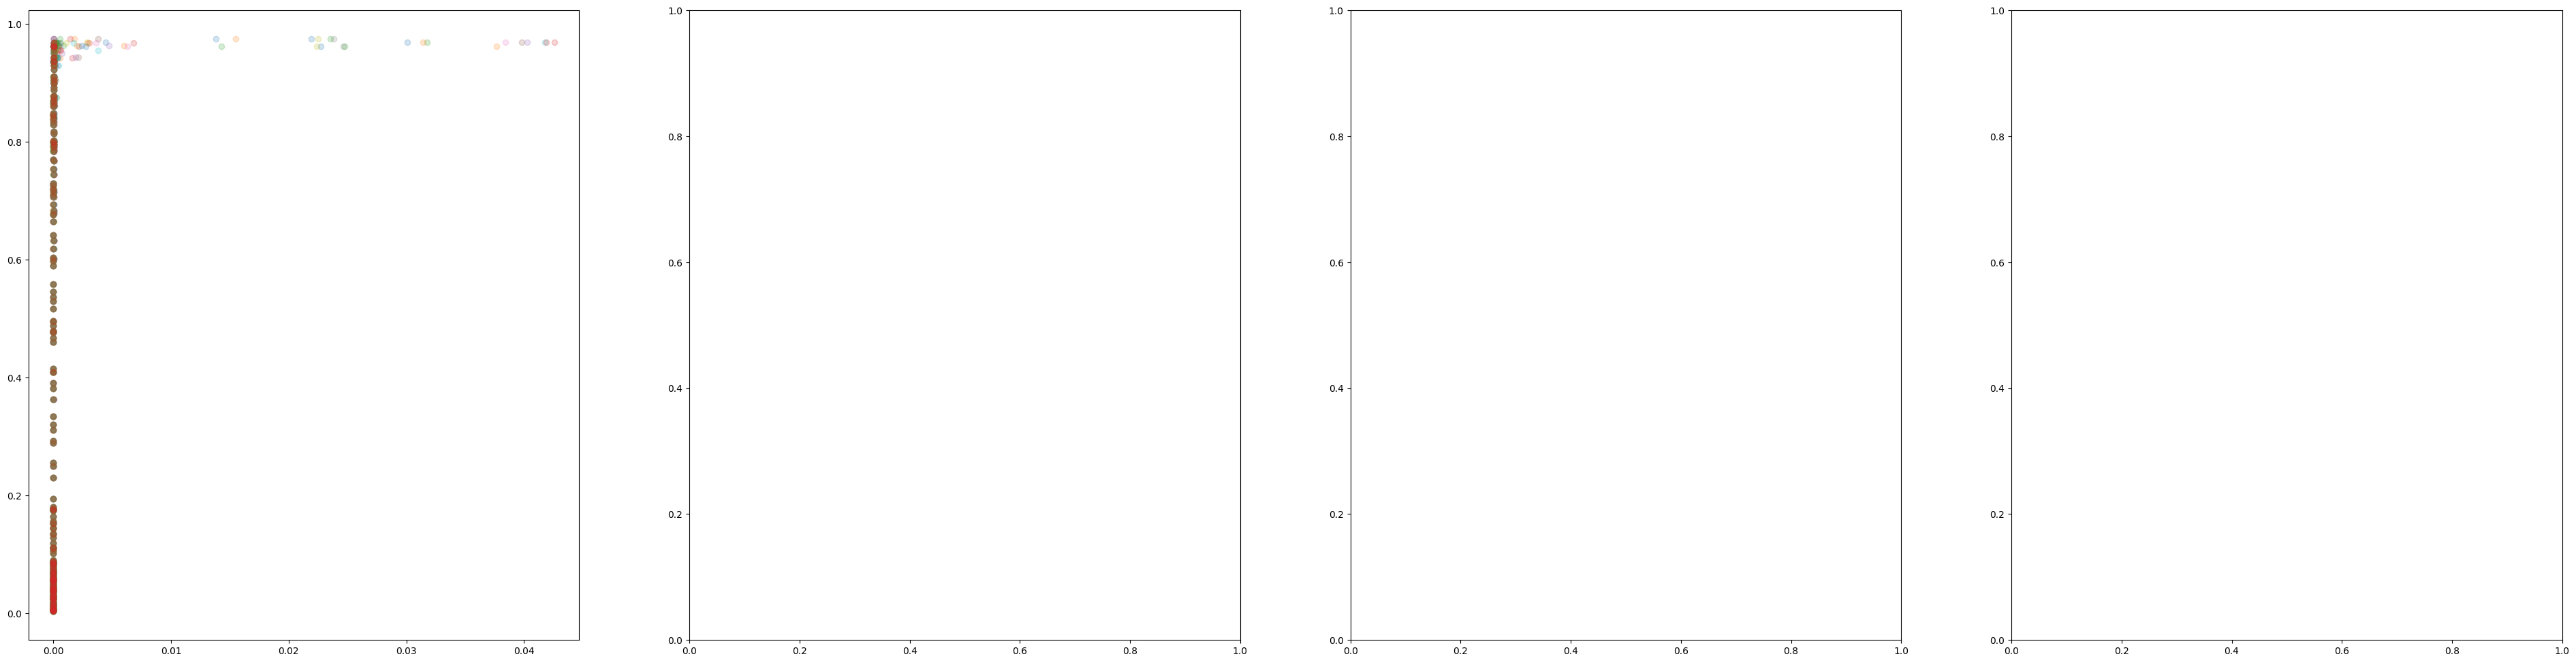

In [34]:
dataset_names = metadataset.get_dataset_names()
fig, axs = plt.subplots(1, 4, figsize=(48, 12))
dropout_rates = [0, 0.25, 0.5, 0.75]

for i,dropout_rate in enumerate(dropout_rates):
    for dataset_name in dataset_names:
        weights, f1_scores = get_weights_and_scores(dataset_name, dropout_rate)
        axs[i].scatter(weights,f1_scores, alpha=0.2)

    axs[i].set_xlabel("Mean Weight Per Pipeline")
    axs[i].set_ylabel("F1-Score")
fig.savefig("saved_plots/hypothesis_overfitting.pdf")

In [27]:
weights.shape

torch.Size([1, 230, 160, 20])

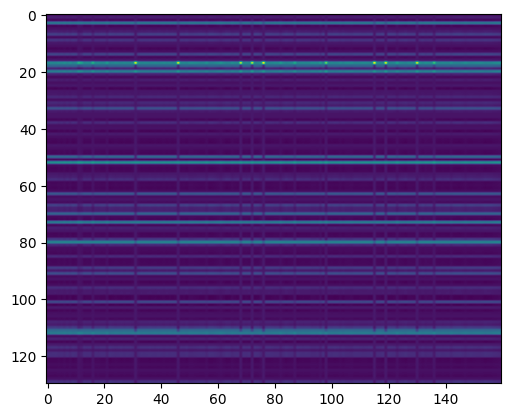

In [18]:
a = weights[0,100:,...,0]
plt.imshow((a-a.mean(0))/a.std(0))

In [20]:
f1_scores = []
for i in range(predictions.shape[1]):

    y_pred = predictions[0][i].argmax(-1).numpy()
    f1_scores.append(f1_score(y_true, y_pred, average=None))
f1_scores = np.array(f1_scores)


tensor(10)
tensor(14)
tensor(10)
tensor(9)
tensor(10)
tensor(12)
tensor(16)
tensor(14)
tensor(16)
tensor(13)
tensor(15)
tensor(9)
tensor(16)
tensor(9)
tensor(12)
tensor(10)
tensor(10)
tensor(7)
tensor(14)
tensor(9)


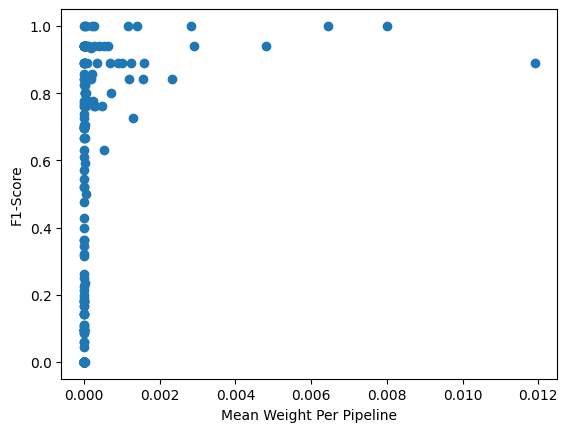

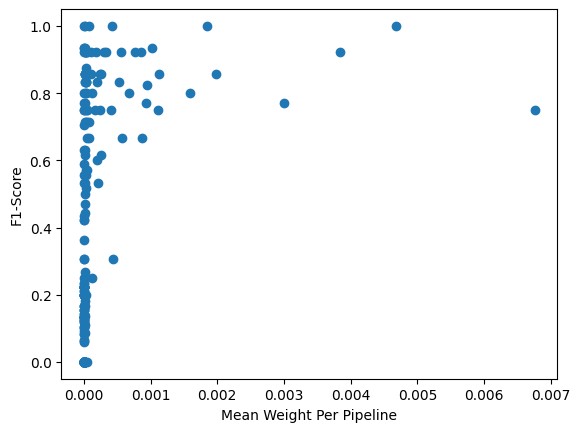

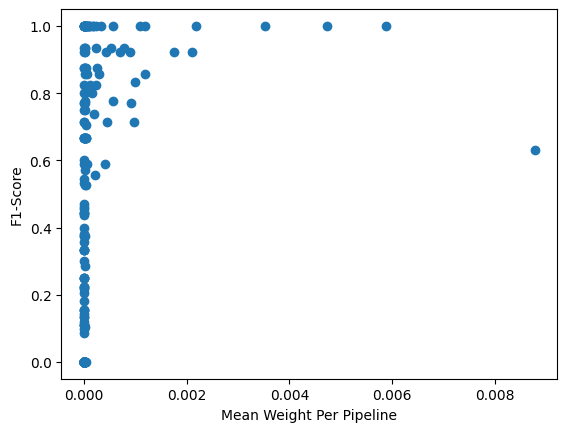

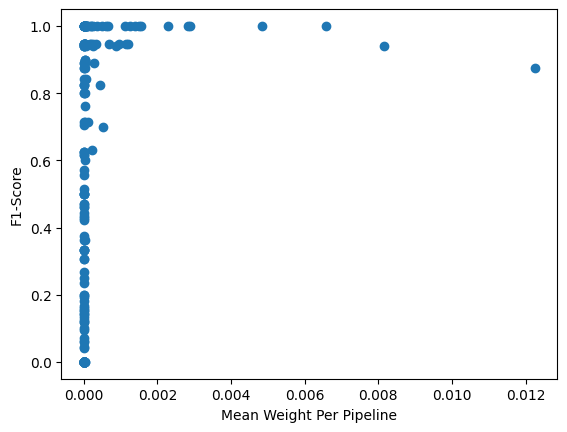

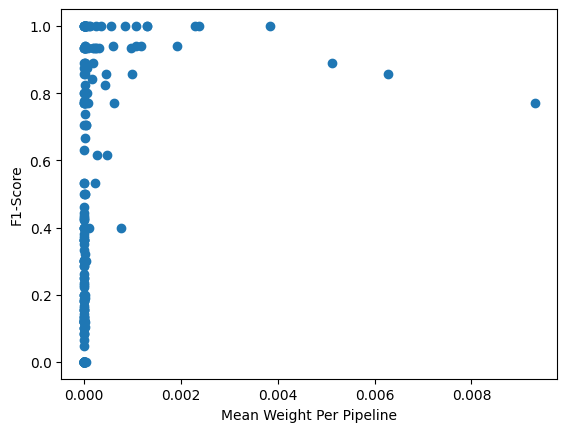

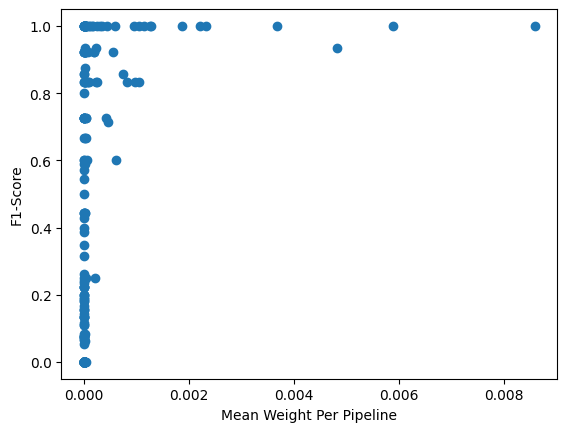

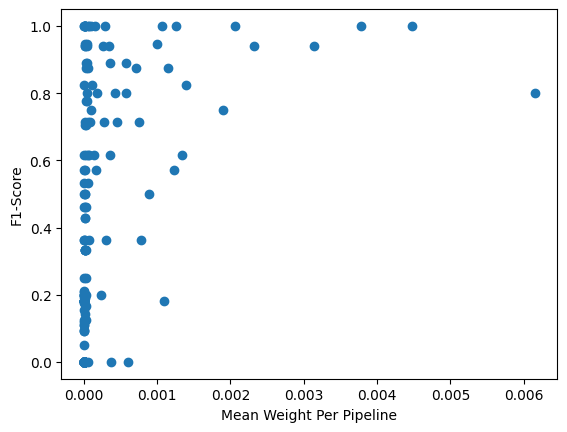

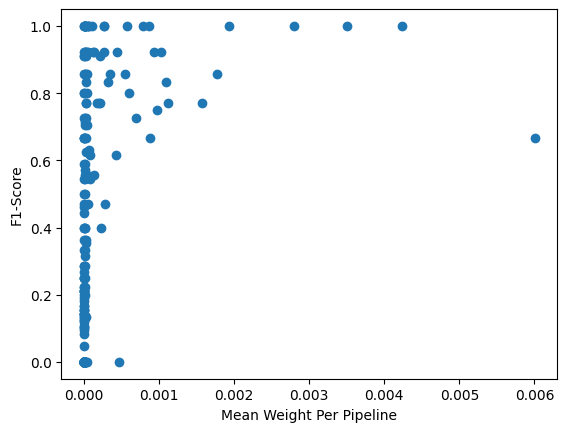

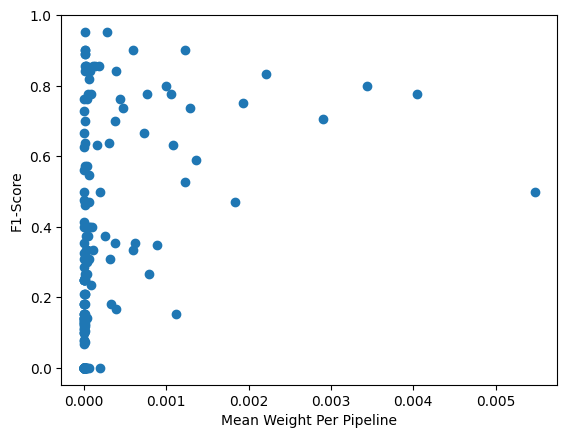

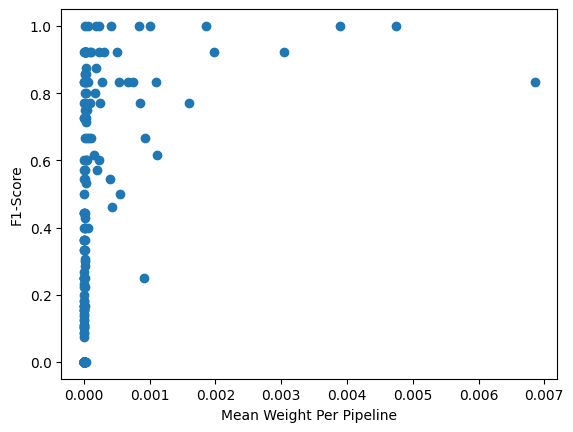

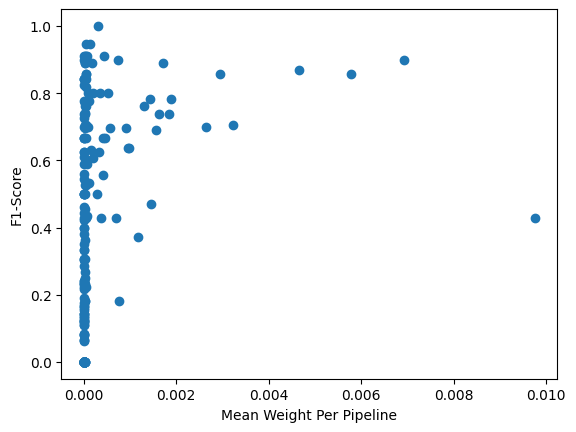

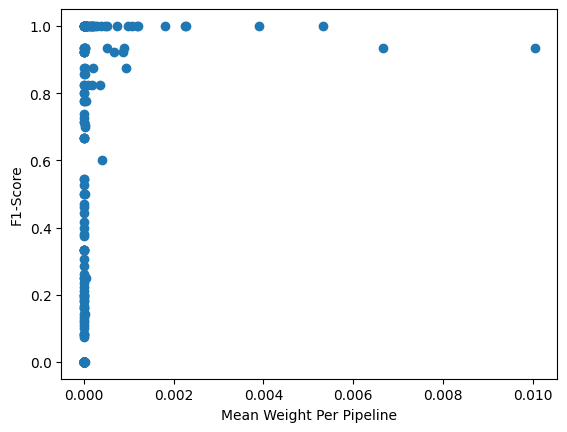

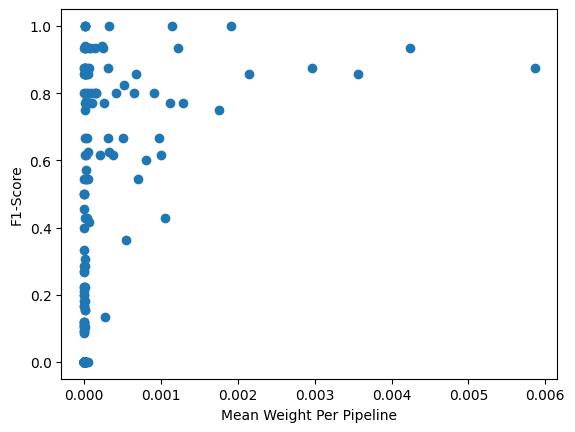

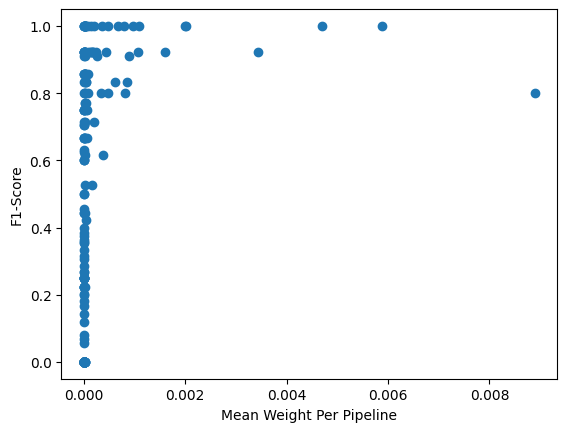

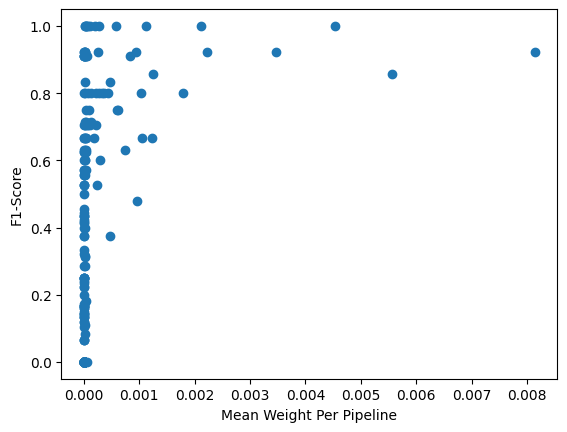

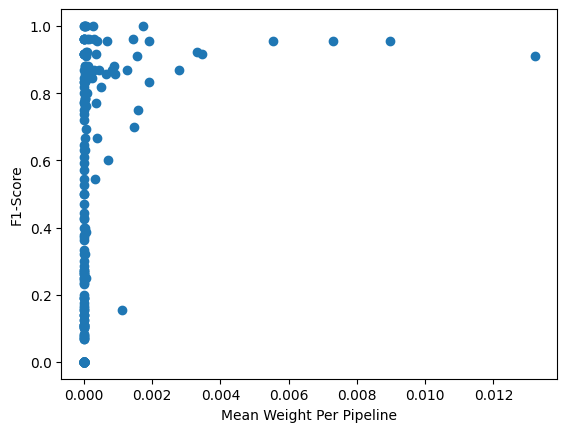

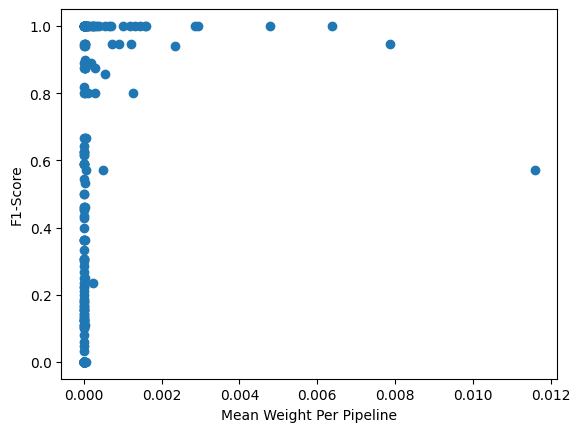

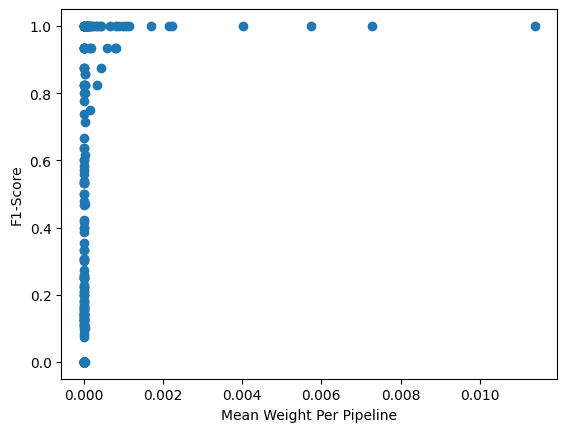

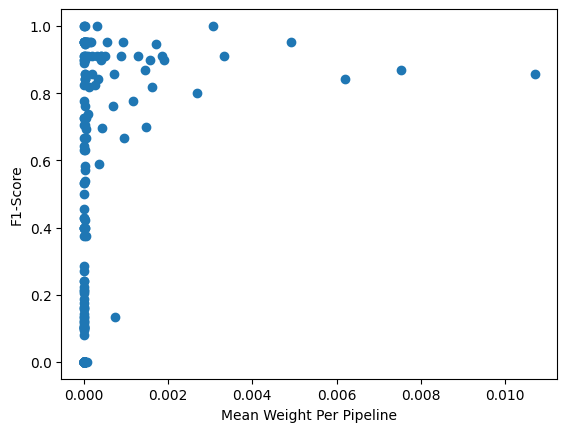

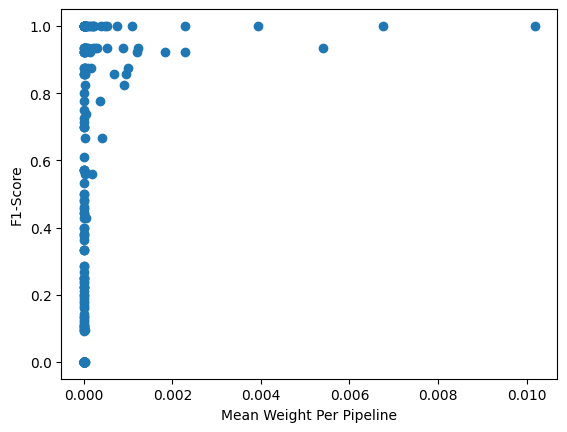

In [21]:

for i in range(f1_scores.shape[1]):
    x = weights[0].mean(axis=-2)[:,i]
    print(((x-x.mean())>x.std()).sum())
    plt.figure()
    plt.scatter(weights[0].mean(axis=-2)[:,i],f1_scores[:,i])
    plt.xlabel("Mean Weight Per Pipeline")
    plt.ylabel("F1-Score")

In [14]:
plt.scatter(weights[0].mean(axis=(-1,-2)),f1_scores.mean(-1)])
plt.xlabel("Mean Weight Per Pipeline")
plt.ylabel("F1-Score")
plt.title(f"Dropout {dropout_rate}")
plt.savefig("saved_plots/hypothesis_overfitting4.png")

SyntaxError: closing parenthesis ']' does not match opening parenthesis '(' (2448388957.py, line 1)

In [8]:
f1_scores.mean(-1).shape

(230,)

In [15]:
y_pred.shape

(160,)

In [16]:
y_pred

array([ 1, 11, 12,  8, 11, 14, 16, 17,  7, 11,  6,  0,  9, 11, 18,  7,  0,
        4, 16, 18, 14,  7,  8, 19,  4, 12, 10, 16, 19,  6,  6,  0,  1, 11,
       18, 15, 19,  8, 17, 16, 19,  3,  1,  8, 18, 10,  0, 17,  6,  8, 16,
       18, 13, 12, 11,  6,  7, 17, 10, 17, 15,  3, 12, 17,  5, 16,  3, 10,
        0,  2,  4,  5,  0,  5, 15,  3,  0,  8, 11, 15, 14, 13, 16, 14,  5,
       15,  3,  9, 18, 10, 13,  6,  2,  3, 16, 15,  4, 17,  0,  2, 11, 10,
       19, 13,  1,  3,  7,  1,  3,  8,  6,  4, 18,  6,  8,  0, 18,  7, 10,
        0, 15,  8,  2,  0, 15, 10,  2, 16, 13, 18,  0,  7,  3, 14, 14, 12,
        9, 18, 15,  4, 15,  8, 13,  6, 19,  2,  5, 12, 13, 12, 19,  4,  3,
       13,  2, 15, 10,  8,  4, 16])

In [22]:
f1_score(y_true, y_pred, average="weighted")

0.8336226330877361